# Erosion glaciaire

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib import animation
import pyproj
from IPython.display import HTML
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

## Implémentation du calcul du taux d'érosion

On utilise l'équation de stream power pour calculer le taux d'érosion :
$$
E = K_g \text{ }.A(x)^m. \text{ } S(x)^n
$$
avec :\
\
$K_g \approx 0.01$ = le coefficient d'érosion glaciaire,\
$S$ = la pente,\
$A$ = le coefficient spatial d'érosion,\
$m,n \in \mathbb{Z}\text{ .}$\
\
Généralement, $m = 1$ et $n = 2$ dans de nombreux modèles d’érosion glaciaire.



In [4]:
def calc_slope(mnt):

    if np.ndim(mnt) == 1:
        slope = np.abs(np.gradient(mnt))
    else:
        dx, dy = np.gradient(mnt)
        slope = np.sqrt(np.clip(dx**2 + dy**2, 0, 1e5)) #La fonction clip sert à éviter les valeurs trop grandes qui pourraient faire crasher le programme.

    slope = np.maximum(slope, 1e-3)
    return slope

In [5]:
def erosion(mnt, K, A):
    
    m=0.5
    n=1

    S = calc_slope(mnt)
    
    E = K * (A**m) * (S**n) 
    
    return E

On paramétrise A de trois manières.

Type **simple** :  
$$ A = 1 \text{ partout.} $$ 

Type **math** :  

On définit $ \mu = l/2$ et $ \sigma = w/2$.\
On a :  
$$
A(x) = \left\{
    \begin{array}{ll}
        1 & \text{si } x \in [\mu - \sigma, \mu + \sigma], \\
        e^{\frac{-(x - \mu)^2}{2 \sigma^2}} & \text{sinon.}
    \end{array}
\right.
$$

Et enfin le type **alt** :  
On a $z_{\text{min}}$ et $z_{\text{max}}$ les altitudes seuils minimales et maximales. On définit $\delta = \frac{z_{\text{max}} - z_{\text{min}}}{2}$ et $z_{\text{moy}} = \frac{z_{\text{max}} + z_{\text{min}}}{2} $.
$$
A = \left\{
    \begin{array}{ll}
        1 & \text{si } z \in [z_{\text{min}}, z_{\text{max}}], \\
        e^{\frac{-(z - z_{\text{moy}})^2}{2 \delta^2}} & \text{sinon}.
    \end{array}
\right.
$$

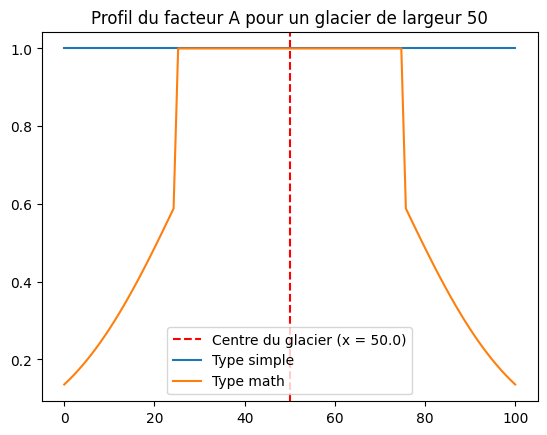

In [6]:
#Faire un graphe du facteur A en fonction de x.

longueur = 100
width = 50
sigma = width/2
mu = longueur/2

x = np.linspace(0, longueur, longueur)

A_simple = np.full_like(x,1)

def A_math(x):
    A = np.full_like(x,0)
    
    A[(np.abs(x) < mu + sigma) & (np.abs(x) >= mu - sigma)] = 1
    A[x > mu + sigma] = np.exp(-(x[x> mu + sigma] -mu)**2 / (2 * sigma**2))
    A[x < mu - sigma] = np.exp(-(x[x < mu - sigma] - mu)**2 / (2 * sigma**2))

    return A
    
A_m = A_math(x)        
plt.axvline(x=longueur/2, color='red', linestyle='--', label=f'Centre du glacier (x = {mu})')

plt.plot(x, A_simple, label = "Type simple")
plt.plot(x, A_m, label = "Type math")
#plt.ylim(-1,2)
plt.legend()
plt.title(f"Profil du facteur A pour un glacier de largeur {width}")
plt.show()

In [7]:
def app_erosion(mnt, K, time, type, stop):
    
    list_mnt = []  

    if type == "simple":
        A =1
        
    elif type == "math":
        w = int(input("Veuillez entrer la largeur du glacier : "))
        
        A = np.full_like(mnt,0)
        
        if np.ndim(mnt) ==1:
            l = np.shape(mnt)[0]
            sigma = w/2
            mu = l/2
            
            x = np.linspace(0, np.shape(mnt)[0], np.shape(mnt)[0])
       
            A[(np.abs(x) <= mu + sigma) & (np.abs(x) >= mu - sigma)] = 1
            A[np.abs(x) > mu + sigma] = np.exp(-(x[np.abs(x)> mu + sigma] - mu)**2 / (2 * sigma**2))
            A[np.abs(x) < mu - sigma] = np.exp(-(x[np.abs(x) < mu - sigma] - mu)**2 / (2 * sigma**2))

        elif np.ndim(mnt) == 2:
            l = np.shape(mnt)[1]
            sigma = w/2
            mu = l/2
            
            X = np.linspace(0, np.shape(mnt)[1], np.shape(mnt)[1])
            Y = np.linspace(0, np.shape(mnt)[0], np.shape(mnt)[0])
            X, Y = np.meshgrid(X, Y)
              
            A[(np.abs(X) <= mu + sigma) & (np.abs(X) >= mu - sigma)] = 1  
            A[np.abs(X) > mu + sigma] = np.exp(-(X[np.abs(X) > mu + sigma] - mu)**2 / (2 * sigma**2))
            A[np.abs(X) < mu - sigma] = np.exp(-(X[np.abs(X) < mu - sigma] - mu)**2 / (2 * sigma**2))

    
    elif type == "alt":
        seuil_min = int(input("Veuillez entrer une altitude minimale pour le glacier : "))
        seuil_max = int(input("Veuillez entrer une altitude maximale pour le glacier : "))
        
        delta = (seuil_max - seuil_min)/2
        moy = delta = (seuil_max + seuil_min)/2
        
        A = np.full_like(mnt,0)
        
        if np.ndim(mnt) == 1:
            x = np.linspace(0, np.shape(mnt)[0], np.shape(mnt)[0])
            
            A[(mnt <= seuil_max) & (mnt>=seuil_min)] = 1
            A[mnt < seuil_min] = np.exp(-(mnt[mnt < seuil_min] - moy)**2/(2*delta**2))
            A[mnt > seuil_max] = np.exp(-(mnt[mnt > seuil_max] - moy)**2/(2*delta**2))
            
        elif np.ndim(mnt) == 2:
            A = np.full_like(mnt,0)
        
            A[(mnt <= seuil_max) & (mnt>=seuil_min)] = 1
            A[mnt < seuil_min] = np.exp(-(mnt[mnt < seuil_min] - moy)**2/(2*delta**2))
            A[mnt > seuil_max] = np.exp(-(mnt[mnt > seuil_max] - moy)**2/(2*delta**2))
            
        
    for t in range(time): #On applique l'érosion sur plusieurs itérations
        
        mnt -= erosion(mnt, K, A)
        
        list_mnt.append(mnt.copy())  # Copie pour éviter l'écrasement des données
        
        if stop == True: #permet d'arrêter les itérations si on atteint une valeur nulle.
            if np.any(mnt <= 0):
                print("STOP à l'itération", t)
                break
        
    return list_mnt

# Terrain en 1D

Pour étudier le comportement de l'érosion glaciaire, nous allons tester le programme sur plusieurs fonctions différentes auxquelles seront ajoutés de petites variations aléatoires dont l'amplitude sera ajustée à la fonction.

## Terrain en V
On paramétrise un terrrain avec la fonction: $$ y = |x| $$

Veuillez entrer la largeur du glacier :  20


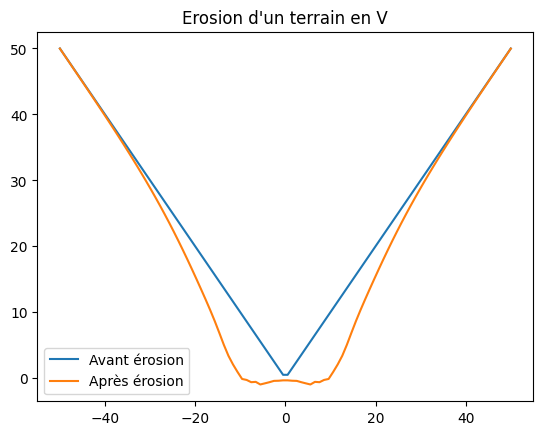

In [8]:
longueur = 100
x = np.linspace(-longueur/2,longueur/2, longueur)
y = np.absolute(x)
y += 1e-3*np.random.rand(np.size(x))

y_erode = app_erosion( y.copy(),K=0.1, time=100, stop = False, type = "math")

plt.plot(x,y, label = "Avant érosion")
plt.plot(x,y_erode[-1], label = "Après érosion")
plt.title("Erosion d'un terrain en V")
plt.legend()
plt.show()

## Vallée parabolique

Veuillez entrer la largeur du glacier :  20


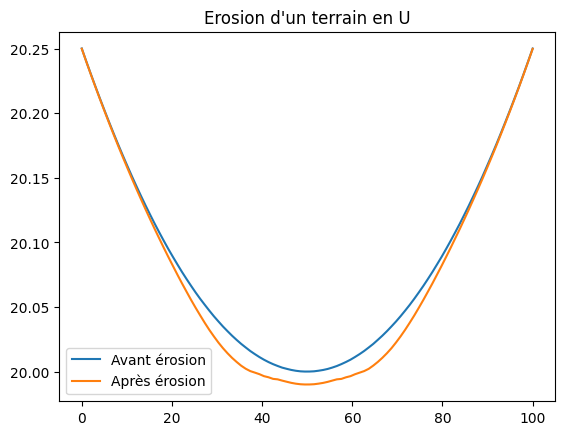

In [9]:
h = 20
longueur = 100
x = np.linspace(0, longueur, longueur)

y = h + (0.01*(x-longueur/2))**2
y += 1e-4*np.random.rand(np.size(x))

y_erode = app_erosion( y.copy(),K=0.1, time=100, type = "math", stop = False)

plt.plot(x,y, label = "Avant érosion")
plt.plot(x,y_erode[-1], label = "Après érosion")
plt.title("Erosion d'un terrain en U")
plt.legend()
plt.show()

## Terrain en vallées
On paramétrise un terrrain en vallées avec la fonction: $$ y = sin(x) $$

Veuillez entrer la largeur du glacier :  20


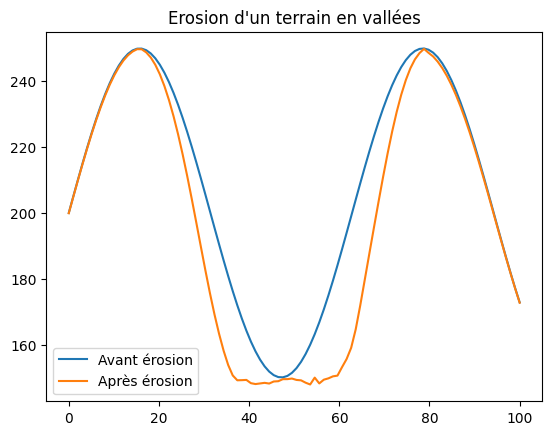

In [10]:
longueur = 100
x = np.linspace(0,longueur, longueur)

y = 50*np.sin(0.1*x) + 200
y += 1e-4*np.random.rand(np.size(x))

y_erode = app_erosion( y.copy(), K=0.1,  time=100,type = "math", stop = False)

plt.plot(x,y, label = "Avant érosion")
plt.plot(x,y_erode[-1], label = "Après érosion")
plt.title("Erosion d'un terrain en vallées")
plt.legend()
plt.show()

## Terrain plat
On paramétrise un terrrain plat avec la fonction: $$ y = h $$ où $h$ est une altitude constante.

Veuillez entrer la largeur du glacier :  20


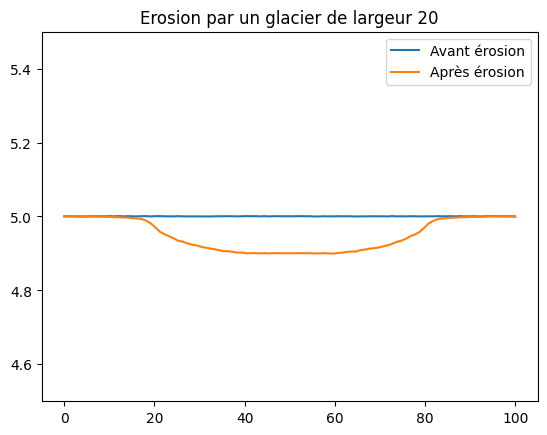

In [11]:
h = 5
x = np.linspace(0,100,100)

y = h*x**0
y += 1e-3*np.random.rand(np.size(x))

y_erode = app_erosion(y.copy(),K=0.01, time=10000, stop = True, type = "math")

plt.ylim(h-h/10,h +h/10)
plt.plot(x,y, label = "Avant érosion")
plt.plot(x,y_erode[-1], label = "Après érosion")

plt.title("Erosion par un glacier de largeur 20")
plt.legend()
plt.show()

# Terrain en 2D

## Terrain en vallées randomisé
On paramétrise la vallée initiale comme suit : $$ Z(X,Y) = \frac{h}{2} sin(0.1 X) + \frac{h}{2} cos(0.1 Y) +h $$
où h est une altitude de base qu'on détermine arbitrairement.

Veuillez entrer une altitude minimale pour le glacier :  50
Veuillez entrer une altitude maximale pour le glacier :  200


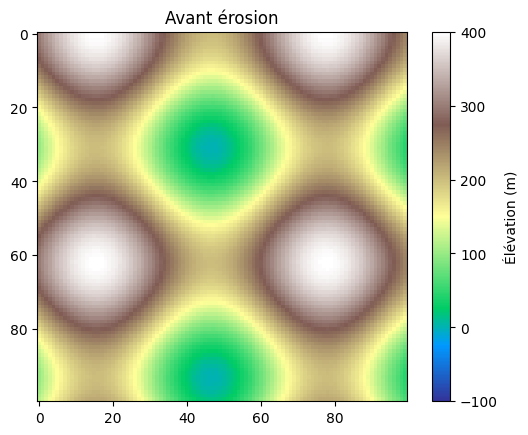

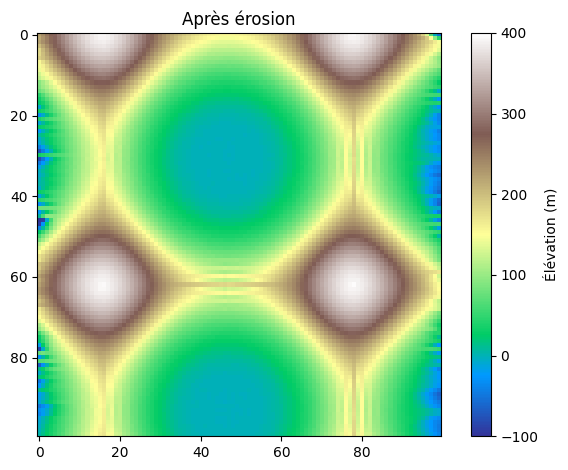

In [12]:
altitude = 200

largeur = 100
longueur = 100

x = np.linspace(0,largeur, largeur)
y=np.linspace(0,longueur,longueur)
[X,Y] = np.meshgrid(x,y)

topo = np.full_like(X, altitude)

topo = altitude/2*np.sin(0.1*X) + altitude + altitude/2*np.cos(0.1*Y)

random_variation = 1e-1*np.random.randn(*topo.shape) * 2  # Variation aléatoire

topo += random_variation  

topo_erode = app_erosion(topo.copy(), K=0.1, time=100, type = "alt",stop=False)

# Définir les limites de la colorbar
vmin = np.min(topo)  
vmax = np.max(topo) 

fig, ax = plt.subplots()
cax = ax.imshow(topo, cmap='terrain', vmin=-100, vmax=vmax)
plt.title("Avant érosion")
plt.colorbar(cax, label='Élévation (m)')

fig, ax = plt.subplots()
cax = ax.imshow(topo_erode[-1], cmap='terrain', vmin=-100, vmax=vmax)
plt.title("Après érosion")
plt.colorbar(cax, label='Élévation (m)', ax=ax)

plt.tight_layout()
plt.show()

## *Louvain-la-Neuve*

In [13]:
# Charger le fichier TIFF
file_path = r"C:\Users\User\Documents\autre\Projets python\ProjetOpenLEM\lln.tif"
with rasterio.open(file_path) as src:
    lln = src.read(1)  # Lecture de la première couche (altitudes)
    transform = src.transform

### Transformer les coordonnées en WGS84

On affiche le système de coordonnées initial

In [14]:
with rasterio.open(file_path) as src:
    # Afficher les informations de projection et de transformation
    print("Système de coordonnées (CRS) :", src.crs)
    print("Transformation affine :", src.transform)

Système de coordonnées (CRS) : EPSG:3035
Transformation affine : | 30.00, 0.00, 3938820.00|
| 0.00,-30.00, 3077230.00|
| 0.00, 0.00, 1.00|


EPSG:3035 correspond à un système de projection en Lambert 93.\
\
Pour la transformation affine: \
(a=30.00, b=0.00) : la taille du pixel en x (ouest à est).\
(d=0.00, e=-30.00) : la taille du pixel en y (nord à sud, avec une échelle négative indiquant un système de coordonnées inversé verticalement). \
(c=3938820.00, f=3077230.00) : les coordonnées géographiques du coin supérieur gauche du raster, en Lambert 93.

In [15]:
# Définir les systèmes de projection (Lambert 93 et WGS84)
lambert93 = pyproj.CRS("EPSG:3035")
wgs84 = pyproj.CRS("EPSG:4326")

# Créer un transformateur de projection
transformer = pyproj.Transformer.from_crs(lambert93, wgs84, always_xy=True)


In [16]:
# Convertir les indices des pixels en coordonnées projetées (EPSG:3035)
x_indices, y_indices = np.meshgrid(np.arange(lln.shape[1]), np.arange(lln.shape[0]))
x_proj, y_proj = rasterio.transform.xy(transform, y_indices, x_indices)

# Appliquer la transformation pour convertir en latitude/longitude (EPSG:4326)
longitudes, latitudes = transformer.transform(x_proj, y_proj)


### Visualiser les données initiales

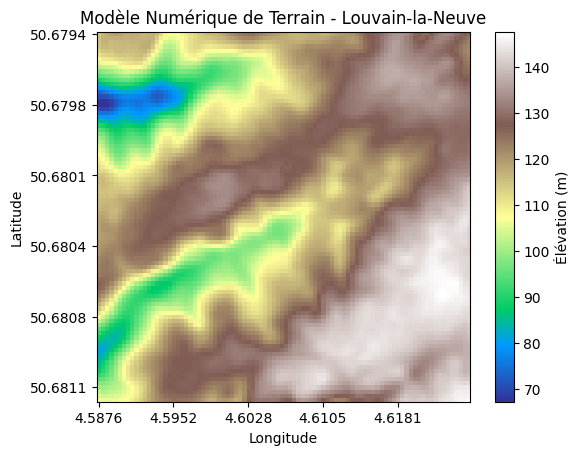

In [17]:
fig, ax = plt.subplots()

cax = ax.imshow(lln, cmap='terrain')

plt.colorbar(cax, label='Élévation (m)')

# Modifier les étiquettes des axes avec les coordonnées géographiques
ax.set_xticks(np.arange(0, lln.shape[1], int(lln.shape[1] / 5)))
ax.set_yticks(np.arange(0, lln.shape[0], int(lln.shape[0] / 5)))

# Utiliser les coordonnées en degrés pour les étiquettes
ax.set_xticklabels([f"{longitudes[i]:.4f}" for i in range(0, lln.shape[1], int(lln.shape[1] / 5))])
ax.set_yticklabels([f"{latitudes[i]:.4f}" for i in range(0, lln.shape[0], int(lln.shape[0] / 5))])

ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude')

plt.title('Modèle Numérique de Terrain - Louvain-la-Neuve')
plt.show()

### Appliquer l'érosion glaciaire à Lln

In [18]:
lln_erode = app_erosion(lln.copy(), K = 0.01, time=1000, type="alt", stop = False)

Veuillez entrer une altitude minimale pour le glacier :  50
Veuillez entrer une altitude maximale pour le glacier :  150


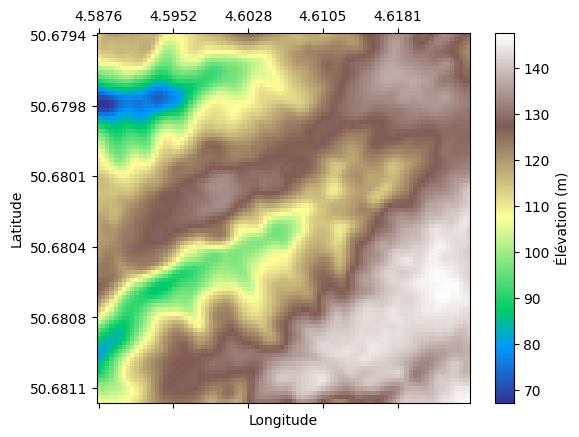

In [19]:
fig, ax = plt.subplots()
mat = ax.matshow(lln, cmap='terrain')

# Définir les limites de la colorbar
vmin = np.min(lln)  
vmax = np.max(lln) 

#ax.imshow(lln_erode[-1], cmap='terrain', vmin=vmin, vmax=vmax)
#plt.title("Après érosion")

plt.colorbar(mat, label='Élévation (m)')

# Modifier les étiquettes des axes avec les coordonnées géographiques
ax.set_xticks(np.arange(0, lln.shape[1], int(lln.shape[1] / 5)))
ax.set_yticks(np.arange(0, lln.shape[0], int(lln.shape[0] / 5)))
ax.set_xticklabels([f"{longitudes[i]:.4f}" for i in range(0, lln.shape[1], int(lln.shape[1] / 5))])
ax.set_yticklabels([f"{latitudes[i]:.4f}" for i in range(0, lln.shape[0], int(lln.shape[0] / 5))])

ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 

plt.show()

In [20]:
###############  ANIMATION  ###############
def update(num, data):
    mat.set_data(data[num])  # Met à jour les données affichées
    ax.set_title(f"Érosion à l'itération {num}")
    return mat,

# Animation
anim = animation.FuncAnimation(fig, update, frames=len(lln_erode), interval=1, fargs=(lln_erode,), blit=False)
 
# Afficher l'animation dans Jupyter Notebook
#HTML(anim.to_jshtml())
mpl.rcParams['animation.embed_limit'] = 50

anim.save(filename='animation_glaciaire_lln.mp4', writer='ffmpeg', fps=100, bitrate=500)

KeyboardInterrupt: 

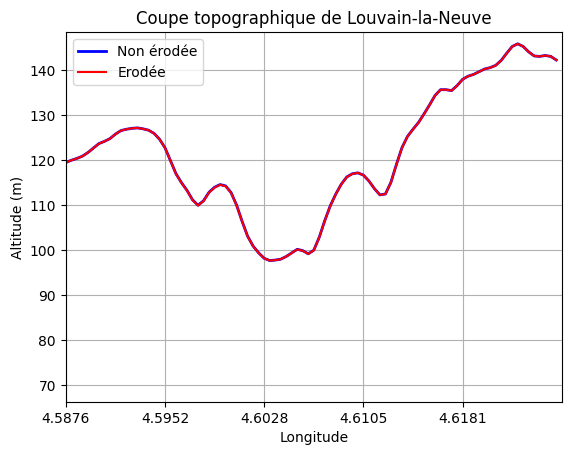

In [21]:
### Récupérer les valeurs d'altitude pour la ligne où y = 50
y_index = 50  
altitudes_at_y_50 = lln[y_index,:] 

x_indices = np.arange(lln.shape[1])

fig, ax = plt.subplots()

#Plot des données initiales
ax.plot(x_indices, lln[y_index, :], color = 'blue', lw=2, label="Non érodée")

#Tirer le # si on veut le tracé fixe des données après l'érosion
#ax.plot(x_indices, lln_erode[-1][y_index, :], color='red', label = "Erodée")

#Ligne qui sert pour l'animation
line, = ax.plot(x_indices, lln_erode[0][y_index, :], color='red', label = "Erodée")

ax.set_xlim(0, len(x_indices))
ax.set_ylim(np.min(lln) - 1, np.max(lln) + 1)
ax.set_title('Coupe topographique de Louvain-la-Neuve')
ax.set_xlabel('Longitude')
ax.set_ylabel('Altitude (m)')
ax.set_xticks(np.arange(0, lln.shape[1], int(lln.shape[1] / 5)))
ax.set_xticklabels([f"{longitudes[i]:.4f}" for i in range(0, lln.shape[1], int(lln.shape[1] / 5))])

plt.grid(True)

plt.legend()
plt.show()


In [ ]:
###############  ANIMATION  ###############
def init():
    line.set_ydata(lln_erode[0][y_index, :])
    return line,
    
def update(num):
    line.set_ydata(lln_erode[num][y_index, :])
    ax.set_title(f"Érosion à l'itération {num}")
    return line,
    
# Animation
anim = animation.FuncAnimation(fig, update, frames=len(lln_erode), init_func = init, interval=1, blit=True)
# Afficher l'animation dans Jupyter Notebook
#HTML(anim.to_jshtml())
mpl.rcParams['animation.embed_limit'] = 50

anim.save(filename='animation_glaciaire_lln_plot.mp4', writer='ffmpeg', fps=100, bitrate=500)

### Vue en 3d

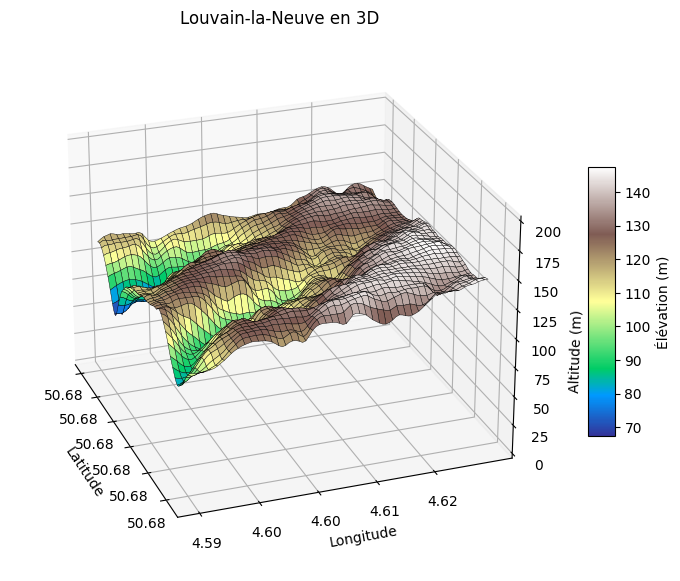

In [22]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

X = np.linspace(0, np.shape(lln)[1], np.shape(lln)[1])
Y = np.linspace(0, np.shape(lln)[0], np.shape(lln)[0])
X, Y = np.meshgrid(X, Y)

vmin = np.min(lln)  
vmax = np.max(lln) 

surf = ax.plot_surface(Y, X, lln, cmap='terrain', edgecolor='k', linewidth=0.3, antialiased=True, vmin=vmin, vmax=vmax)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Élévation (m)')


# Modifier les étiquettes des axes avec les coordonnées géographiques
ax.set_yticks(np.arange(0, lln.shape[1], int(lln.shape[1] / 5)))
ax.set_xticks(np.arange(0, lln.shape[0], int(lln.shape[0] / 5)))

ax.set_yticklabels([f"{longitudes[i]:.2f}" for i in range(0, lln.shape[1], int(lln.shape[1] / 5))])
ax.set_xticklabels([f"{latitudes[i]:.2f}" for i in range(0, lln.shape[0], int(lln.shape[0] / 5))])
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Altitude (m)')
ax.set_title('Louvain-la-Neuve en 3D')

ax.set_zlim(0, 200)
ax.view_init(elev=25, azim=340)

plt.show()

In [ ]:
###############  ANIMATION  ###############
def update(num, data):
    global surf
    surf.remove()
    surf = ax.plot_surface(Y, X, lln_erode[num], cmap='terrain', vmin=vmin, vmax=vmax)

    ax.set_title(f"Érosion à l'itération {num}")
    return surf,

anim = animation.FuncAnimation(fig, update, frames=len(lln_erode), fargs=(lln_erode,), interval=1, blit=False)

# Sauvegarder l'animation
anim.save(filename='animation_glaciaire_lln_3d.mp4', writer='ffmpeg', fps=100, bitrate=500)

plt.show()

## *Mer de glace du Mont Blanc*

### Visualisation des données initiales et transformations des coordonnées

In [24]:
# Charger le fichier TIFF
file_path_2 = r"C:\Users\User\Documents\autre\Projets python\ProjetOpenLEM\mer_de_glace.tif"

with rasterio.open(file_path_2) as src:
    mdg = src.read(1)  # Lecture de la première couche (altitudes)
    transform2 = src.transform

In [25]:
with rasterio.open(file_path_2) as src:
    # Afficher les informations de projection et de transformation
    print("Système de coordonnées (CRS) :", src.crs)
    print("Transformation affine :", src.transform)

Système de coordonnées (CRS) : EPSG:3035
Transformation affine : | 30.00, 0.00, 4078290.00|
| 0.00,-30.00, 2541670.00|
| 0.00, 0.00, 1.00|


In [26]:
# Convertir les indices des pixels en coordonnées projetées (EPSG:3035)
x_indices2, y_indices2 = np.meshgrid(np.arange(mdg.shape[1]), np.arange(mdg.shape[0]))
x_proj2, y_proj2 = rasterio.transform.xy(transform2, y_indices2, x_indices2)

# Appliquer la transformation pour convertir en latitude/longitude (EPSG:4326)
longitudes2, latitudes2 = transformer.transform(x_proj2, y_proj2)

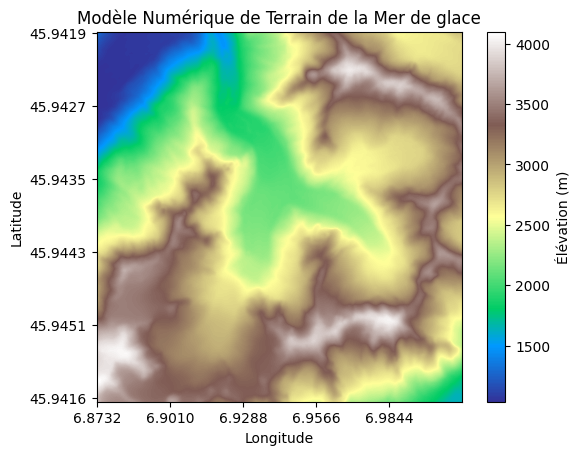

In [27]:
fig, ax = plt.subplots()

cax = ax.imshow(mdg, cmap='terrain')

plt.colorbar(cax, label='Élévation (m)')

# Modifier les étiquettes des axes avec les coordonnées géographiques
ax.set_xticks(np.arange(0, mdg.shape[1], int(mdg.shape[1] / 5)))
ax.set_yticks(np.arange(0, mdg.shape[0], int(mdg.shape[0] / 5)))
ax.set_xticklabels([f"{longitudes2[i]:.4f}" for i in range(0, mdg.shape[1], int(mdg.shape[1] / 5))])
ax.set_yticklabels([f"{latitudes2[i]:.4f}" for i in range(0, mdg.shape[0], int(mdg.shape[0] / 5))])
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 

plt.title('Modèle Numérique de Terrain de la Mer de glace')
plt.show()

In [29]:
mdg_erode = app_erosion(mdg.copy(), K = 0.01, time= 1000, stop = True, type = "alt")

Veuillez entrer une altitude minimale pour le glacier :  2000
Veuillez entrer une altitude maximale pour le glacier :  3000


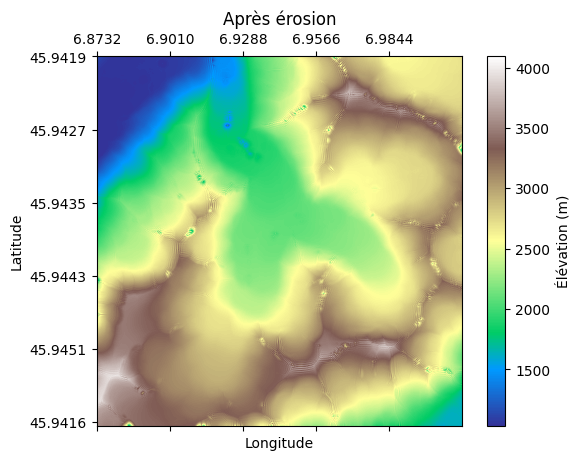

In [30]:
fig, ax = plt.subplots()
mat = ax.matshow(mdg_erode[0], cmap='terrain')

# Définir les limites de la colorbar
vmin = np.min(mdg) 
vmax = np.max(mdg) 

ax.imshow(mdg_erode[-1], cmap='terrain', vmin=vmin, vmax=vmax)

plt.title("Après érosion")
plt.colorbar(mat, label='Élévation (m)')

# Modifier les étiquettes des axes avec les coordonnées géographiques
ax.set_xticks(np.arange(0, mdg.shape[1], int(mdg.shape[1] / 5)))
ax.set_yticks(np.arange(0, mdg.shape[0], int(mdg.shape[0] / 5)))
ax.set_xticklabels([f"{longitudes2[i]:.4f}" for i in range(0, mdg.shape[1], int(mdg.shape[1] / 5))])
ax.set_yticklabels([f"{latitudes2[i]:.4f}" for i in range(0, mdg.shape[0], int(mdg.shape[0] / 5))])
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 

plt.show()

In [ ]:
###############  ANIMATION  ###############
def update(num, data):
    mat.set_data(data[num])  # Met à jour les données affichées
    ax.set_title(f"Érosion à l'itération {num}")
    return mat,

# Animation
anim = animation.FuncAnimation(fig, update, frames=len(mdg_erode), interval=100, fargs=(mdg_erode,), blit=False)

# Afficher l'animation dans Jupyter Notebook
HTML(anim.to_jshtml())
#anim.save(filename='animation_glaciaire_mer_de_glace.mp4', writer='ffmpeg', fps=30)

# La vallée de Chamonix

In [31]:
# Charger le fichier TIFF
file_path_3 = r"C:\Users\User\Documents\autre\Projets python\ProjetOpenLEM\chamonix.tif"

with rasterio.open(file_path_3) as src:
    cha = src.read(1)  # Lecture de la première couche (altitudes)
    transform3 = src.transform

In [32]:
with rasterio.open(file_path_3) as src:
    # Afficher les informations de projection et de transformation
    print("Système de coordonnées (CRS) :", src.crs)
    print("Transformation affine :", src.transform)

Système de coordonnées (CRS) : EPSG:3035
Transformation affine : | 30.00, 0.00, 4073070.00|
| 0.00,-30.00, 2545030.00|
| 0.00, 0.00, 1.00|


In [33]:
# Convertir les indices des pixels en coordonnées projetées (EPSG:3035)
x_indices3, y_indices3 = np.meshgrid(np.arange(cha.shape[1]), np.arange(cha.shape[0]))
x_proj3, y_proj3 = rasterio.transform.xy(transform3, y_indices3, x_indices3)

# Appliquer la transformation pour convertir en latitude/longitude (EPSG:4326)
longitudes3, latitudes3 = transformer.transform(x_proj3, y_proj3)

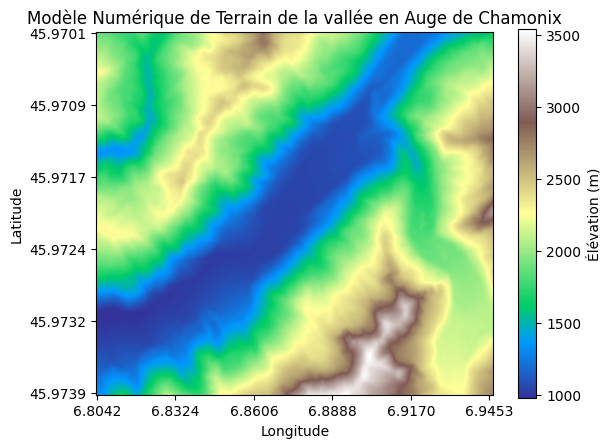

In [34]:
fig, ax = plt.subplots()

cax = ax.imshow(cha, cmap='terrain')

plt.colorbar(cax, label='Élévation (m)')

# Modifier les étiquettes des axes avec les coordonnées géographiques
ax.set_xticks(np.arange(0, cha.shape[1], int(cha.shape[1] / 5)))
ax.set_yticks(np.arange(0, cha.shape[0], int(cha.shape[0] / 5)))

ax.set_xticklabels([f"{longitudes3[i]:.4f}" for i in range(0, cha.shape[1], int(cha.shape[1] / 5))])
ax.set_yticklabels([f"{latitudes3[i]:.4f}" for i in range(0, cha.shape[0], int(cha.shape[0] / 5))])
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 

plt.title('Modèle Numérique de Terrain de la vallée en Auge de Chamonix')
plt.show()

### Coupes topographiques

#### Coupe horizontale

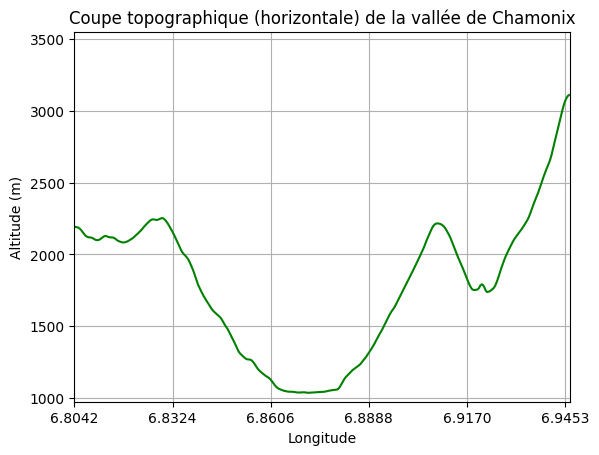

In [35]:
### Récupérer les valeurs d'altitude pour la ligne où y = 50

y_index_3 = int(cha.shape[0]/2)  
altitudes_at_y_50 = cha[y_index_3,:]    

x_indices3 = np.arange(cha.shape[1])

fig, ax = plt.subplots()
ax.set_xlim(0, len(x_indices3))
ax.set_ylim(np.min(cha) - 1, np.max(cha) + 1)
ax.set_title('Coupe topographique (horizontale) de la vallée de Chamonix')
ax.set_xlabel('Longitude')
ax.set_ylabel('Altitude (m)')

ax.plot(x_indices3, altitudes_at_y_50, color='green')

# Configuration des ticks de l'axe des abscisses
tick_positions = np.arange(0, cha.shape[1], int(cha.shape[1] / 5))
ax.set_xticks(tick_positions)
ax.set_xticklabels([f"{longitudes3[i]:.4f}" for i in tick_positions])

ax.grid(True)
plt.show()


#### Coupe verticale

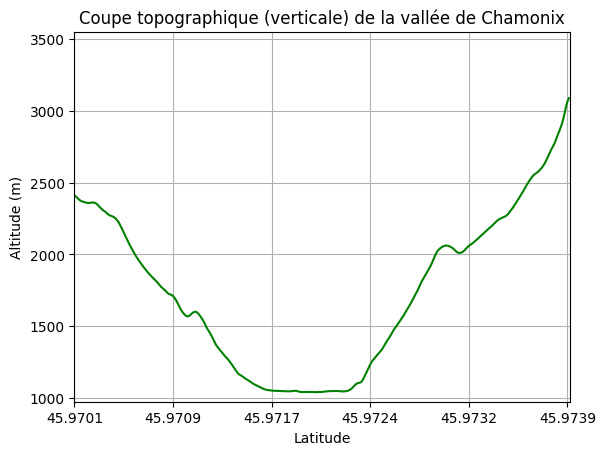

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que cha et latitudes3 soient déjà définis

# Récupérer les valeurs d'altitude pour la colonne où x = 50 (fixe)
x_index_3 = int(np.shape(cha)[1]/2)  # Indice pour la colonne souhaitée
altitudes_at_x_50 = cha[:, x_index_3]

y_indices3 = np.arange(cha.shape[0])

# Tracer l'altitude en fonction de y (pour x constant)
fig, ax = plt.subplots()
ax.set_ylim(np.min(cha) - 1, np.max(cha) + 1)
ax.set_xlim(0, len(y_indices3))  # L'axe y va de 0 à la taille de la matrice
ax.set_title('Coupe topographique (verticale) de la vallée de Chamonix')
ax.set_ylabel('Altitude (m)')
ax.set_xlabel('Latitude')

ax.plot(y_indices3,altitudes_at_x_50, color='green')

# Configuration des ticks de l'axe des ordonnées
tick_positions = np.arange(0, cha.shape[0], int(cha.shape[0] / 5))
ax.set_xticks(tick_positions)
ax.set_xticklabels([f"{latitudes3[i]:.4f}" for i in tick_positions])

ax.grid(True)

plt.show()


#### Coupe en diagonale

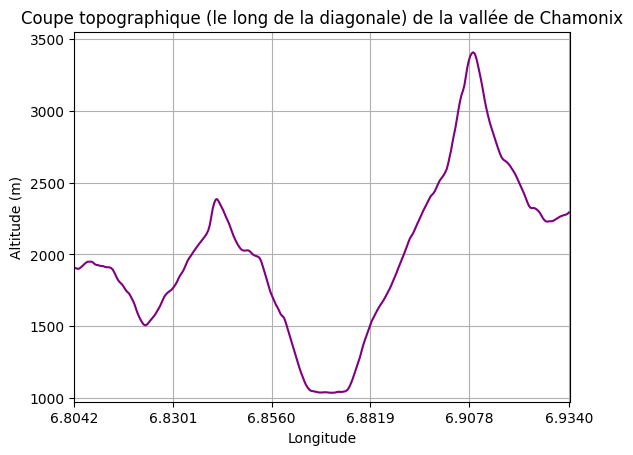

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que cha et longitudes3 soient déjà définis

# Extraire les valeurs d'altitude le long de la diagonale principale
altitudes_diagonale = np.diagonal(cha)

# Créer des indices pour la diagonale (les indices sont les mêmes pour x et y sur une diagonale principale)
x_indices_diag = np.arange(len(altitudes_diagonale))

# Tracer l'altitude en fonction des indices diagonaux
fig, ax = plt.subplots()
ax.set_xlim(0, len(x_indices_diag))
ax.set_ylim(np.min(cha) - 1, np.max(cha) + 1)
ax.set_title('Coupe topographique (le long de la diagonale) de la vallée de Chamonix')
ax.set_xlabel('Longitude')
ax.set_ylabel('Altitude (m)')

ax.plot(x_indices_diag, altitudes_diagonale, color='purple')

# Configuration des ticks de l'axe des abscisses
tick_positions = np.linspace(0, len(x_indices_diag) - 1, 6, dtype=int)
ax.set_xticks(tick_positions)
ax.set_xticklabels([f"{longitudes3[i]:.4f}" for i in tick_positions])

ax.grid(True)

plt.show()


#### Coupe de l'autre diagonale

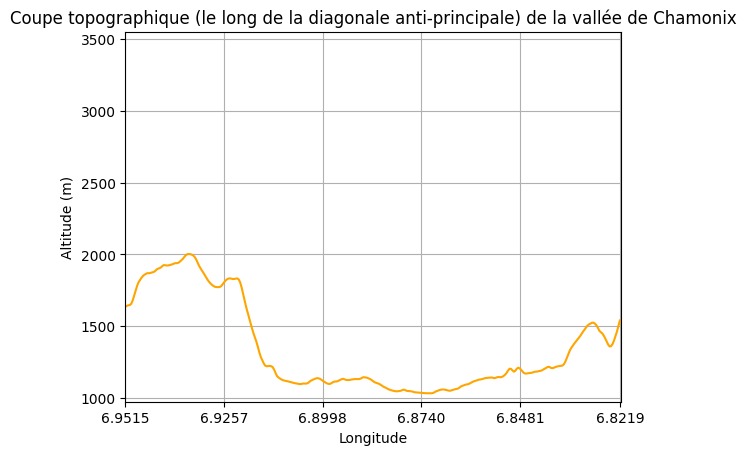

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que cha et longitudes3 soient déjà définis

# Extraire les valeurs d'altitude le long de la diagonale anti-principale
altitudes_anti_diagonale = np.diagonal(np.fliplr(cha))

# Créer des indices pour la diagonale (les indices sont les mêmes pour x et y sur une diagonale anti-principale)
x_indices_anti_diag = np.arange(len(altitudes_anti_diagonale))

# Tracer l'altitude en fonction des indices diagonaux
fig, ax = plt.subplots()
ax.set_xlim(0, len(x_indices_anti_diag))
ax.set_ylim(np.min(cha) - 1, np.max(cha) + 1)
ax.set_title('Coupe topographique (le long de la diagonale anti-principale) de la vallée de Chamonix')
ax.set_xlabel('Longitude')
ax.set_ylabel('Altitude (m)')

ax.plot(x_indices_anti_diag, altitudes_anti_diagonale, color='orange')

# Configuration des ticks de l'axe des abscisses
tick_positions = np.linspace(0, len(x_indices_anti_diag) - 1, 6, dtype=int)
ax.set_xticks(tick_positions)
ax.set_xticklabels([f"{longitudes3[-(i + 1)]:.4f}" for i in tick_positions])

ax.grid(True)

plt.show()


### Vue en 3D

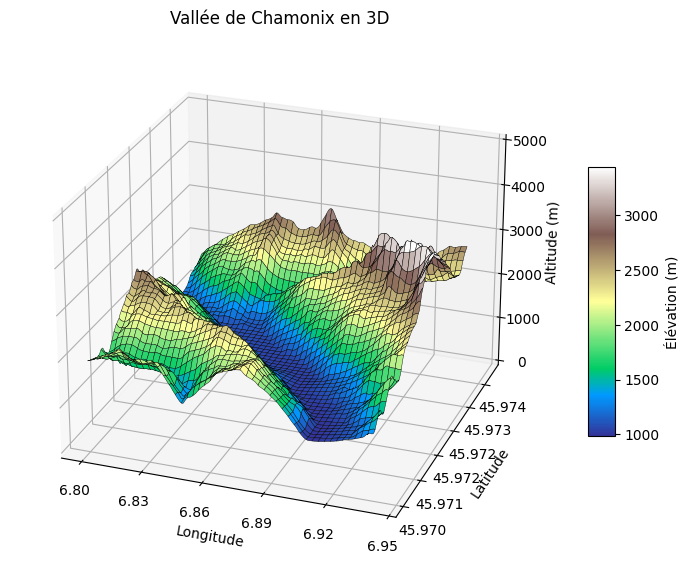

In [39]:
# Création de la figure et de l'axe 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

X = np.linspace(0, np.shape(cha)[1], np.shape(cha)[1])
Y = np.linspace(0, np.shape(cha)[0], np.shape(cha)[0])
X, Y = np.meshgrid(X, Y)

# Tracer la surface
surf = ax.plot_surface(Y, X, cha, cmap='terrain', edgecolor='k',linewidth=0.3, antialiased=True)

# Ajouter une barre de couleur
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Élévation (m)')

ax.set_xticks(np.arange(0, cha.shape[1], int(cha.shape[1] / 5)))
ax.set_yticks(np.arange(0, cha.shape[0], int(cha.shape[0] / 5)))

ax.set_xticklabels([f"{longitudes3[i]:.2f}" for i in range(0, cha.shape[1], int(cha.shape[1] / 5))])
ax.set_yticklabels([f"{latitudes3[i]:.3f}" for i in range(0, cha.shape[0], int(cha.shape[0] / 5))])
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 

ax.set_zlabel('Altitude (m)')
ax.set_title('Vallée de Chamonix en 3D')

ax.set_zlim(000, 5000)
ax.view_init(elev=25, azim=-70)

plt.show()

# Références

- Hergarten, Stefan. (2021). A stream-power law for glacial erosion and its implementation in large-scale landform-evolution models. 10.5194/esurf-2021-1.
- Hengl, Tomislav, Leal Parente, Leandro, Krizan, Josip, and Bonannella, Carmelo. 2022. Continental Europe Digital Terrain Model.  Distributed by OpenTopography. https://doi.org/10.5069/G99021ZF. Accessed: 2024-12-05.
- Liebl, Moritz & Robl, Jörg & Hergarten, Stefan & Egholm, David & Stüwe, Kurt. (2023). Modeling large‐scale landform evolution with a stream power law for glacial erosion (OpenLEM v37): benchmarking experiments against a more process-based description of ice flow (iSOSIA v3.4.3). _Geoscientific Model Development_. 16. 1315-1343. 10.5194/gmd-16-1315-2023. 